# Beijing Trajectories - Project Summary

**Overview**

A data science research project in the Applied Mathematics & Mathematical Physics Group at Imperial College London. Used fractal and complexity measures on a dataset of users’ locations which were tracked in and around Beijing. Extracted each user's significant locations as well as classifying different trajectories using some methods from statistical physics.

**Stages**

- Data Cleaning
- Location clustering
- User analysis
- Trajectory analysis

## Data Cleaning

The raw data form (https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/) had uneven time-steps, duplicate users, mislabelled trajectories and noisy data-points amongst other errors.

See the *Primary Time-step and Position Analysis* notebook for justifications of the time-step resampling and conversion from lat/long coordinates to cartesian coordinates (with choice of origin).

One of the most troublesome formatting problems with the data was that many trajectories had multiple corresponding labels (i.e. they contained more than one mode of transport), all stored in a separate table. The *Cleaning* folder contains scripts for splitting up these trajectories into their constituent parts as well as general scripts for converting formats, relabelling columns, label matching, converting date-time formats and other boring but necessary tasks that needed to be carried out before analysis.

**resample.py** contains the time-step resampling methods. This was carried out in realtime, so as to avoid a large redundancy in the stored data. The time-step resolution was taken to be a low percentile (typically the 10th) of the original distribution of time-steps in a particular trajectory (chosen to be roughly above the noisy points). An extrapolation was carried out over the final point.

Criteria were also imposed on the velocities represented in the trajectory. When a trajectory object was created, it was automatically analysed to detect if there were velocities above a certain pre-defined threshold set for that mode of transport. Time-steps which exceeded these velocities were discarded. If ten of these time steps were detected then the trajectory was labelled as 'dirty' and completely discarded. 

## Location Clustering

**Splitting the trajectories**

Not only did single trajectories contain multiple labels, but users often stopped for prolonged periods of time, perhaps in their workplace for example. For this reason, I needed to use spatio-temporal clustering on the timestamped locations within each of the trajectories. This was implemented as a spatio-temporal DBSCAN in stdbscan.py, which was modified from https://github.com/eubr-bigsea/py-st-dbscan.

This st_dbscan was given maximum distance and time clustering parameters as well as an extra condition where the time spent in a certain location (represented by a detected cluster) had to be larger than a certain threshold. In this way we can be fairly certain that the two sub-trajectories either side of the cluster represented two different 'trips'.

Unfortunately, the algorithm was fairly slow (especially given the size of the dataset and that I was working on my machine), therefore I didn't apply it in any meaningful way and instead filtered to trajectories of duration less than an hour so I could be fairly certain they weren't made up of smaller sub-trajectories.


**Mining the significant locations**

I applied a simple DBSCAN to the start and end points of the trajectories of specific users to determine their most popular locations.

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from Scripts.userAnalysis import user
from Scripts.chooseUsr import randUsr
from matplotlib import pyplot as plt

Trying three different random users from the example data.

In [12]:
u1 = user(randUsr('../Example Data'))

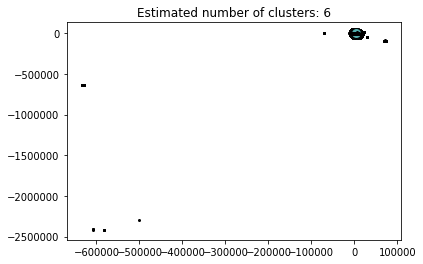

In [14]:
u1.plotClusters()

In [15]:
u2 = user(randUsr('../Example Data'))

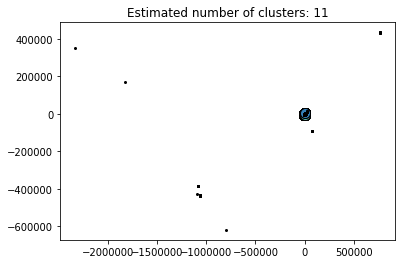

In [16]:
u2.plotClusters()

In [25]:
u3 = user('../Example Data/064')

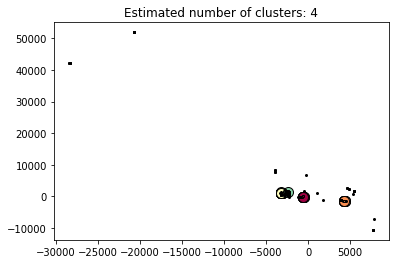

In [8]:
u3.plotClusters()

It's hard to see the clusters on this scale, but the algorithm seemed to do a pretty good job once you inspect at smaller scales. The following plots are slighty easier to read, they plot every trajectory as well as the significant locations.

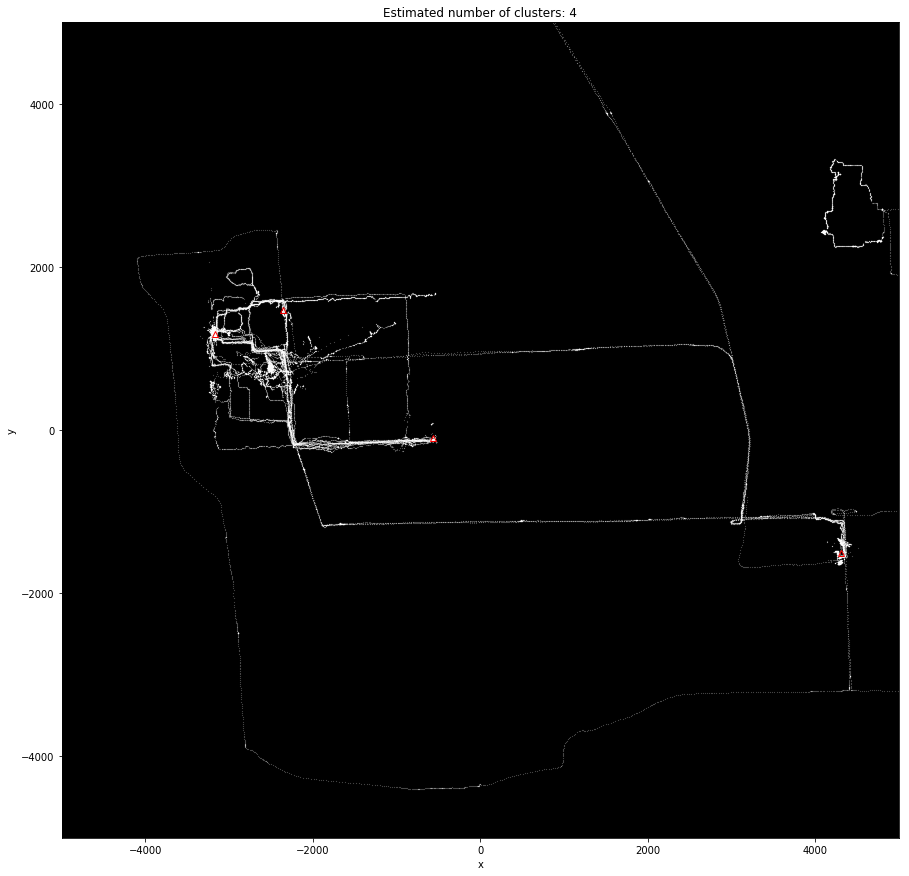

In [20]:
u3.plotAllTrajs()
plt.rcParams["figure.figsize"] = [8,8]
plt.xlim(-5000,5000)
plt.ylim(-5000,5000)
plt.show()

The location of these clusters was defined as the geometric median of all points contained in the cluster. They are more apparent from the data if one plots a heatmap of the start and end locations.

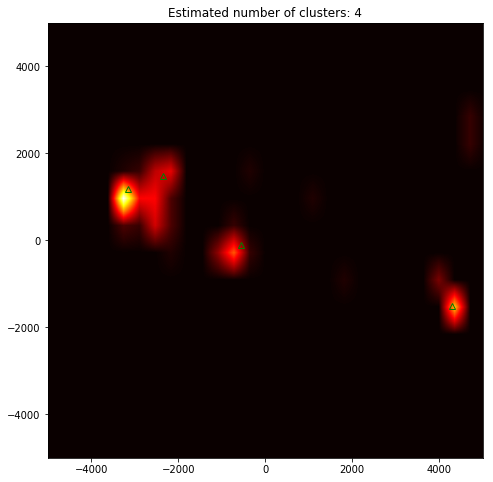

In [27]:
u3.startEnd_heatmap()
plt.rcParams["figure.figsize"] = [8,8]
plt.xlim(-5000,5000)
plt.ylim(-5000,5000)
plt.show()

From these locations, I planned to analyse their distribution to perhaps find some power-law distribution, or maybe some scale invariance. However, other analysis eventually took precedence.

## Further User Data

I also wrote a few other routines for further analysis of a particular user. I'll take u3 as our example.

We can see their most popular modes of transport (simply extracted from the matched metadata):

In [28]:
u3.modeInfo()

Number of Labelled Trajectories: 68/89


Transportation Mode
walk    24
bike    23
bus     20
run      1
Name: Transportation Mode, dtype: int64

Their activity over the full range of recording:

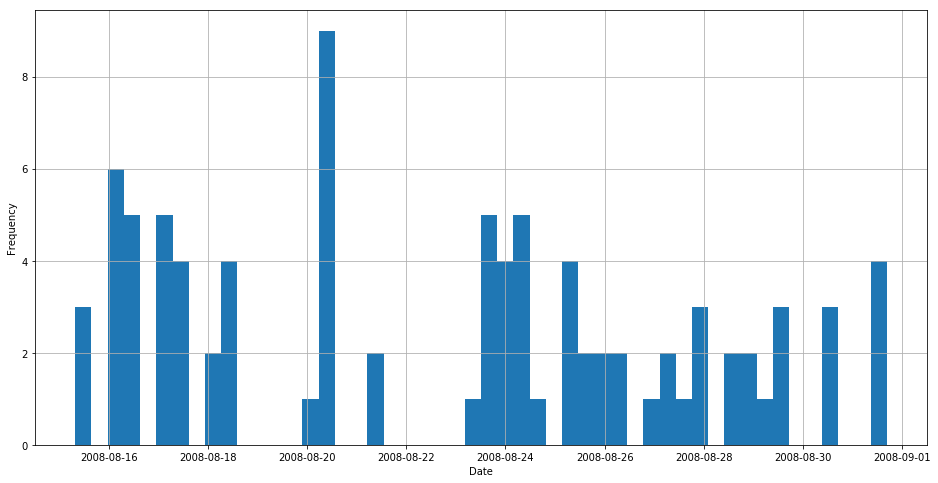

In [34]:
u3.dates_hist()
plt.rcParams["figure.figsize"] = [8,4]
plt.show()

This particular user only recorded data over the space of 2 months.

## Trajectory Analysis

The data thus far has been useful for analysing the behaviour of a single user, however, to make broader analysis on the nature of these trips in general, as well as to classify them, I wanted to include trajectories from a larger range of users. This section details the analysis that I carried out.

In [54]:
from Scripts.trajAnalysis import trajectory
from Scripts.chooseTraj import randTraj
from matplotlib import pyplot as plt

Just as an idea of what one of these trajectories looks like (all distances are in $m$).

In [69]:
t1 = trajectory(randTraj('../Example Data'))

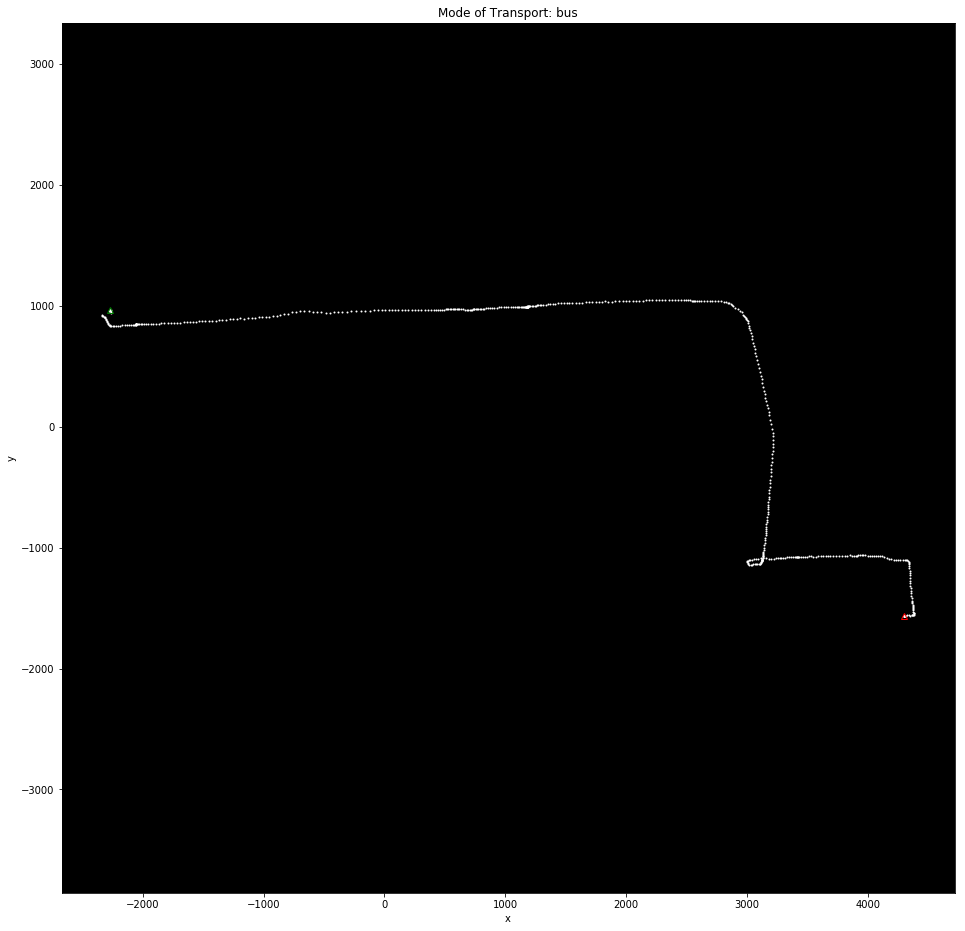

In [86]:
t1.plotTraj()
plt.rcParams["figure.figsize"] = [16,16]
plt.axes().set_aspect('equal', 'datalim')
clear_output()
plt.show()

The green and red triangles represent the start and end of the trajectory respectively.

One of the most useful quantities for mode of transport classification was the turning angle density - that is, the sum of the absolute angles turned at each timestep divided by either the length or duration of the trajectory. The idea behind this was that we'd expect walkers to turn more per unit length than say a car etc.

In [81]:
from Scripts.generalAnalysis import *
from IPython.display import clear_output

In [78]:
# The full inventory of trajectories, made to speed up filtering and analysis
idf = pd.read_csv('../Metadata/Inventory.csv')

# The directory containing all of the data
root = '../../Data'

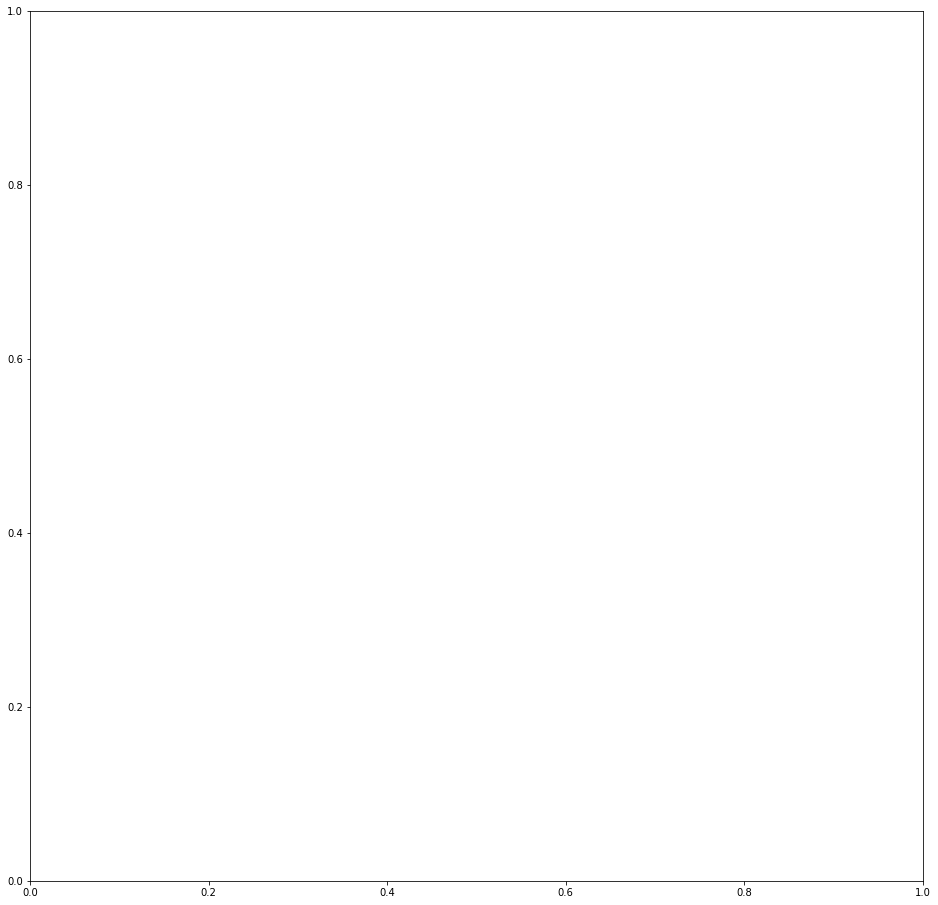

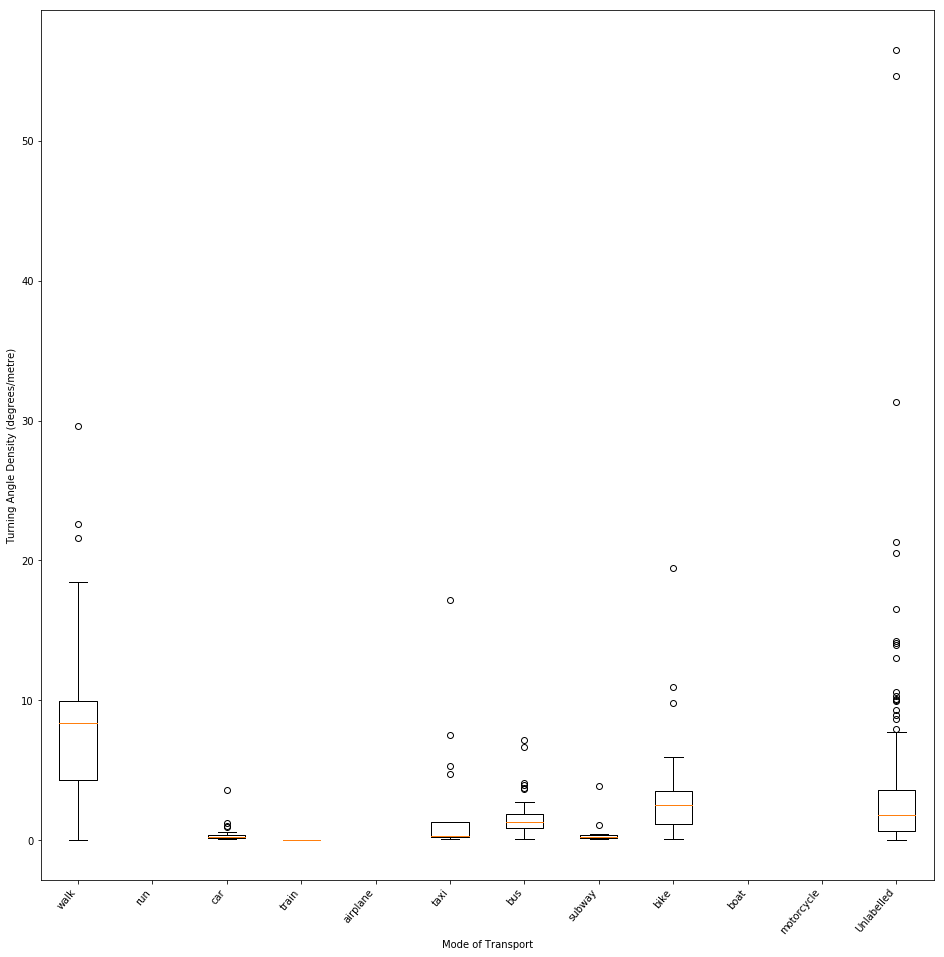

In [82]:
angleS_mode(root, samples=500)
clear_output()
plt.show()

This metric could definitely be used as one of the features in a classification algorithm.

One of the most striking results was uncovering a scaling relation between the the area covered and the length of the trip.

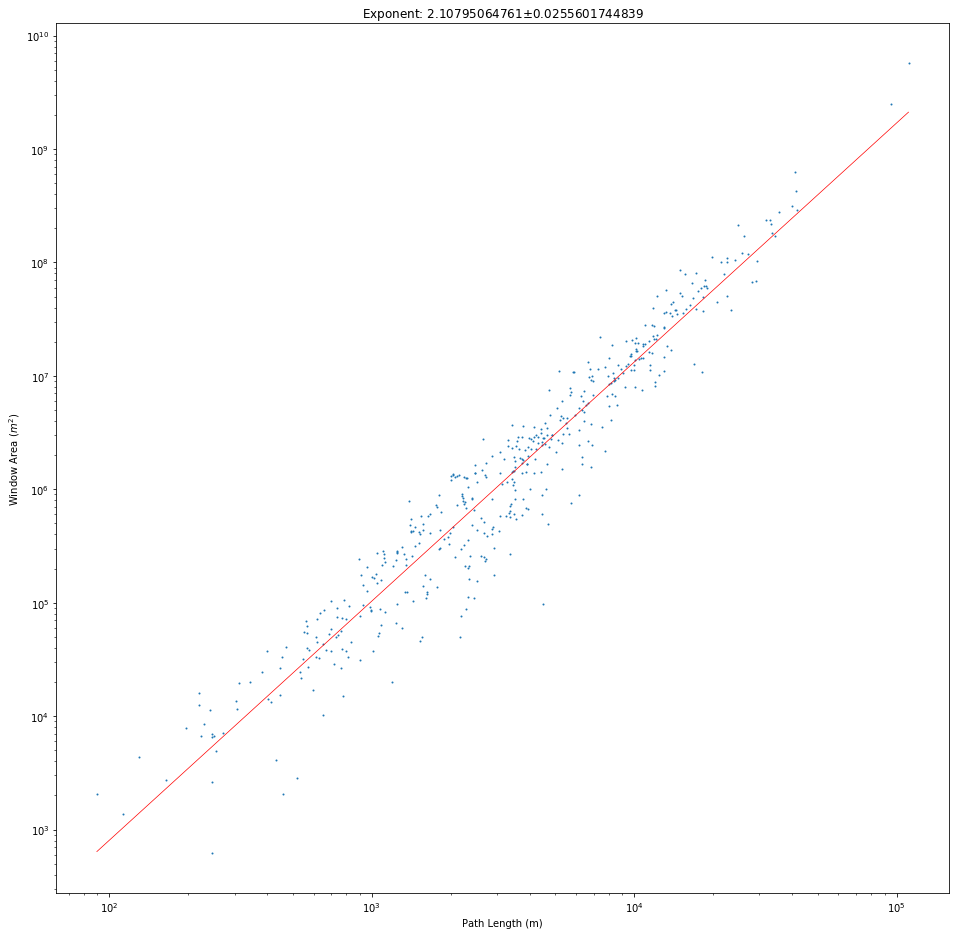

In [84]:
area_length(root, samples=500)
clear_output()
plt.show()

This essentially suggests that trips that are longer tend to be straighter, characterised by this scaling exponent for the window area against path length of $\sim 2.11$. 

Plots were also made involving the correlation dimensions and hurst exponents of the trajectories but they proved less insightful.  